In [5]:
from __future__ import print_function
import pandas as pd
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


def download_file(file_url, folder_path, data_folder, file_name):
#     file_path = os.path.join(folder_path, data_folder, file_name)
    file_path = os.getcwd()+ data_folder+ file_name
    if not os.path.exists(file_path):
        print('Downloading file from ' + file_url + '...')
        urlretrieve(file_url, file_path)
        print('Done downloading file: '+file_path)
        input_file= pd.read_csv(url)
    else:
#         print('File: ' + file_path + ' already exists.')
        print(file_name + ' imported from local computer ')
        input_file= pd.read_csv(os.getcwd()+data_folder + file_name)
    return input_file


def download_dataset():
    print('Downloading Endava support tickets dataset...')
    folder_path =   os.getcwd() #os.path.join(         os.path.dirname(             os.path.abspath(__file__)        ),        'datasets'    )
    url = "https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv"
    data_folder = "\Input_dataset\\"
    file_name = 'all_tickets.csv'
    input_data = download_file(url, folder_path, data_folder, file_name)
    return input_data


if __name__ == "__main__":
    emails_df= download_dataset()

all_tickets.csv imported from local computer 


In [4]:
import os, sys, email, re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Network analysis
import networkx as nx


# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer





In [168]:
emails_df = emails_df[emails_df['title'].notna()]
emails_df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4
5,mail,verification warning hi has got attached pleas...,1,4,3,7,89,3,4


# Topic Modelling on Title 

In [169]:
import spacy
from spacy.lang.en import English
# spacy.load('en')

parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [170]:
import nltk
import re

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [171]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [172]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
  
    
    tokens = [token.replace("\'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("[", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("]'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("\n'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("\r'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token for token in tokens if token not in en_stop]
    tokens= filter(lambda ThisWord: not re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', ThisWord), tokens)
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

<>:12: DeprecationWarning: invalid escape sequence \/
<>:12: DeprecationWarning: invalid escape sequence \/
<>:12: DeprecationWarning: invalid escape sequence \/
<ipython-input-172-751d22501113>:12: DeprecationWarning: invalid escape sequence \/
  tokens= filter(lambda ThisWord: not re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', ThisWord), tokens)


In [181]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
import random
text_data = []

for line in emails_df['title']:
    tokens = prepare_text_for_lda(line)
#     print(tokens)
    text_data.append(tokens)

In [175]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [176]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5, iterations=500)

In [177]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.300*"access" + 0.096*"request" + 0.052*"network" + 0.050*"connection" + 0.041*"confluence" + 0.029*"monitor" + 0.026*"document" + 0.025*"site" + 0.025*"client" + 0.024*"needed"')
(1, '0.290*"oracle" + 0.101*"project" + 0.083*"account" + 0.078*"pa" + 0.034*"service" + 0.033*"code" + 0.025*"fusion" + 0.021*"available" + 0.019*"wrong" + 0.016*"leaver"')
(2, '0.093*"password" + 0.067*"change" + 0.045*"reset" + 0.037*"team" + 0.034*"status" + 0.031*"critical" + 0.022*"accessing" + 0.022*"external" + 0.021*"detail" + 0.021*"contact"')
(3, '0.230*"error" + 0.074*"laptop" + 0.030*"open" + 0.027*"server" + 0.027*"day" + 0.027*"list" + 0.023*"ticket" + 0.023*"work" + 0.021*"urgent" + 0.015*"help"')
(4, '0.340*"issue" + 0.046*"window" + 0.039*"user" + 0.038*"approval" + 0.034*"log" + 0.032*"timecard" + 0.031*"upgrade" + 0.028*"phone" + 0.020*"license" + 0.015*"mailbox"')
(5, '0.152*"time" + 0.093*"unable" + 0.083*"report" + 0.056*"missing" + 0.042*"notification" + 0.038*"add" + 0.029*"subm

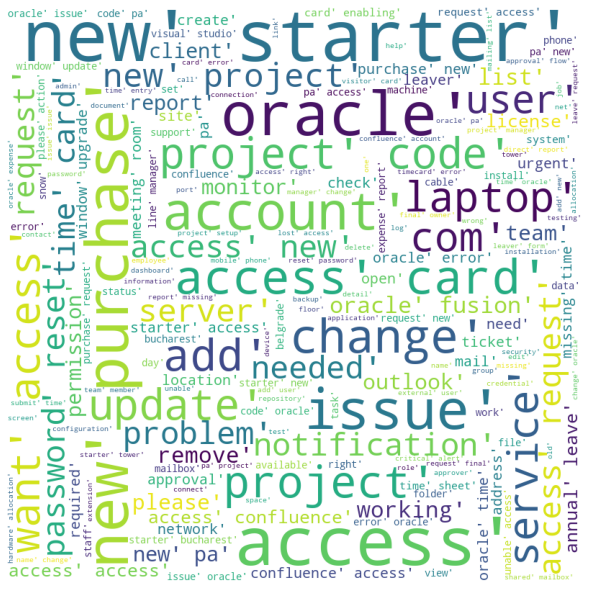

In [178]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [179]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.289265 -0.156013       1        1  12.622534
1     -0.230147 -0.204397       2        1  12.175649
8      0.044965  0.130531       3        1  11.069910
4      0.004644  0.268560       4        1  10.740933
3      0.014337  0.083162       5        1  10.047950
5     -0.040048  0.187030       6        1  10.029713
9      0.274379 -0.160188       7        1   9.703633
2     -0.088057 -0.069606       8        1   8.861051
6     -0.239166 -0.156493       9        1   7.444301
7     -0.030171  0.077415      10        1   7.304324, topic_info=             Term         Freq        Total Category  logprob  loglift
214         issue  5076.000000  5076.000000  Default  30.0000  30.0000
15         access  6411.000000  6411.000000  Default  29.0000  29.0000
32            new  4569.000000  4569.000000  Default  28.0000  28.0000
58         oracle  5773.000000  5773.000000  Default  27.0000  27.0000
274         error  3215.000000  3215.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
294      database    57.762871    58.679562  Topic10  -5.1701   2.6010
2072  implemented    55.814819    56.731575  Topic10  -5.2044   2.6004
381    management   155.628494   214.545624  Topic10  -4.1790   2.2957
541       machine   102.989563   183.714844  Topic10  -4.5918   2.0379
369          data   101.404800   199.683472  Topic10  -4.6073   1.9391

[372 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1718      5  0.994368     able
447       2  0.992926  absence
15        1  0.820495   access
15        7  0.179040   access
15       10  0.000312   access
...     ...       ...      ...
1322      9  0.986326  without
4         5  0.996841     work
904       7  0.999098  working
473       1  0.990321    write
222       2  0.996335    wrong

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 9, 5, 4, 6, 10, 3, 7, 8])

# Topic Modelling on message contents

In [203]:
#import os

In [184]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.add('thanks')
en_stop.add('please')
en_stop.add('hello')
en_stop.add('regards')
en_stop.add('regard')
en_stop.add('dear')
en_stop.add('thank')
en_stop.add('help')
en_stop.add('kind')
en_stop.add('name')
en_stop.add('also')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [196]:
import random
text_data = []

for line in emails_df['body']:
    tokens = prepare_text_for_lda(line)
#     print(tokens)
    text_data.append(tokens)

In [197]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [200]:
import gensim
NUM_TOPICS = 10
ldamodel_body = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5, iterations=500)

In [194]:
topics = ldamodel_body.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.062*"password" + 0.053*"following" + 0.025*"line" + 0.023*"registered" + 0.021*"information" + 0.018*"client" + 0.016*"change" + 0.015*"kingdom" + 0.014*"number" + 0.013*"intended"')
(1, '0.079*"mailbox" + 0.055*"leaver" + 0.046*"mobile" + 0.044*"message" + 0.042*"full" + 0.038*"phone" + 0.032*"center" + 0.031*"account" + 0.025*"approver" + 0.023*"extension"')
(2, '0.044*"july" + 0.025*"change" + 0.021*"know" + 0.021*"meeting" + 0.014*"room" + 0.013*"event" + 0.012*"list" + 0.010*"care" + 0.010*"contract" + 0.009*"let"')
(3, '0.046*"report" + 0.032*"approval" + 0.021*"update" + 0.021*"action" + 0.021*"task" + 0.019*"detail" + 0.016*"date" + 0.016*"assigned" + 0.014*"expense" + 0.014*"know"')
(4, '0.031*"issue" + 0.019*"ticket" + 0.016*"need" + 0.016*"ext" + 0.016*"best" + 0.015*"high" + 0.014*"tuesday" + 0.014*"engineer" + 0.013*"work" + 0.013*"wednesday"')
(5, '0.049*"administrator" + 0.041*"log" + 0.041*"cable" + 0.035*"device" + 0.035*"purchase" + 0.032*"monitor" + 0.031*"ord

In [195]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_body, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.137644 -0.057812       1        1  20.286350
8      0.125361 -0.323279       2        1  13.503633
2     -0.145153 -0.023742       3        1  11.662279
3     -0.036186 -0.024409       4        1  11.370889
9     -0.013754 -0.059257       5        1  11.017242
7     -0.188107  0.086018       6        1   9.551894
6     -0.173630  0.185282       7        1   7.030446
0      0.071478 -0.125112       8        1   6.325130
5      0.236382  0.189431       9        1   5.169389
1      0.261253  0.152879      10        1   4.082745, topic_info=          Term          Freq         Total Category  logprob  loglift
9139      sent  20165.000000  20165.000000  Default  30.0000  30.0000
1064    access  16384.000000  16384.000000  Default  29.0000  29.0000
156     report   7057.000000   7057.000000  Default  28.0000  28.0000
68    password   5263.000000   5263.000000  Default  27.0000  27.0000
59       issue  13482.000000  13482.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
165       date    859.242798   6161.855469  Topic10  -4.1507   1.2283
336     number    679.474731   4531.221191  Topic10  -4.3854   1.3010
344        due    467.900330   1556.537842  Topic10  -4.7585   1.9964
475       form    484.250458   4080.592041  Topic10  -4.7241   1.0670
328      floor    429.645172   3253.857910  Topic10  -4.8438   1.1738

[629 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9143      1  0.002539       able
9143      2  0.996818       able
1064      4  0.024780     access
1064      6  0.075073     access
1064      7  0.900082     access
...     ...       ...        ...
939       5  0.114049      write
939       6  0.884800      write
9477      7  0.995980     yammer
2387      1  0.993479  yesterday
2387      8  0.005651  yesterday

[1283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 3, 4, 10, 8, 7, 1, 6, 2])